## Setup

In [958]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Tests
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import VarianceThreshold, RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [959]:
class Logit_model:
    
    def __init__(self, X, y):
        self.X0, self.X1, self.Y0, self.Y1 = train_test_split(X, y, test_size=0.25, random_state=42)
        self.X = X
        self.y = y

    def skLogit(self):
        result = LogisticRegression(random_state=42, class_weight='balanced', 
                                    max_iter=200).fit(self.X0,self.Y0)
        return result
    
    def statLogit(self, maxiter=70):
        result = sm.Logit(self.Y0, self.X0).fit(maxiter=maxiter)
        return result

    def model_performance(self):
        model = self.skLogit()
        
        Y0_predict = model.predict(self.X0)
        Y1_predict = model.predict(self.X1)

        Y0_hat = model.predict_proba(self.X0)[:, 1]
        Y1_hat = model.predict_proba(self.X1)[:, 1]

        print('\nROC AUC Train', roc_auc_score(self.Y0, Y0_hat).round(3))
        print('ROC AUC Test', roc_auc_score(self.Y1, Y1_hat).round(3))
        print('-------------------------')
        print('\nClassification Report Train')
        print(classification_report(self.Y0, Y0_predict))
        print('-------------------------')
        print('\nClassification Report Test')
        print(classification_report(self.Y1, Y1_predict))
        print('-------------------------')

        cnf_matrix = confusion_matrix(self.Y1, Y1_predict)
        class_names = [0, 1]  # name  of classes
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        # create heatmap
        sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

    def vif(self):
        # Calculating VIF
        vifc = pd.DataFrame()
        vifc["variables"] = self.X.columns
        vifc["VIF"] = [variance_inflation_factor(self.X.values, i) for i in range(self.X.shape[1])]
        vifc = vifc.sort_values(by='VIF', ascending=False).reindex()
        return(vifc)

    def best_features(self, n_features):
        estimator = self.skLogit()
        selector =  RFE(estimator, n_features, step=1)
        selector.fit(self.X0, self.Y0)
        n_feature_rankings = 1
        best_features = self.X0.columns[selector.ranking_ <= n_feature_rankings]
        return best_features

def low_freq_combine(data, columns, threshold_percent=1):
    data = data.copy()
    for column in columns:
        series = pd.value_counts(data[column])
        mask = (series/series.sum() * 100).lt(threshold_percent)
        low_freq_updated = np.where(df[column].isin(series[mask].index), 'Other', df[column])
        data[column] = low_freq_updated
    return data

def explain_components(price_dummies, dummy_comps_explain):
    main_comp_corrls = pd.concat([price_dummies, dummy_comps_explain], axis=1).corr()[dummy_comps_explain.columns]
    
    comps_explained = []
    for c in dummy_comps_explain.columns:
        compParts = main_comp_corrls.sort_values(by=c, ascending=False).index
        comps_explained.append(compParts)

    comps_explained_df = pd.DataFrame(comps_explained).transpose()
    comps_explained_df.columns = dummy_comps_explain.columns
    return comps_explained_df

## Data Cleanup

In [960]:
purchaseData = pd.read_csv('./purchase data.csv')
segmentationData = pd.read_csv('./segmentation-data.csv')

purchaseData['ID'] = purchaseData.ID - 100000000

data = purchaseData.merge(segmentationData)

In [961]:
data.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,0,67,2,124670,1,2
1,100000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,67,2,124670,1,2
2,100000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,67,2,124670,1,2
3,100000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,0,67,2,124670,1,2
4,100000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,0,67,2,124670,1,2


In [962]:
dummies = ['Incidence', 'Brand', 'Last_Inc_Brand', 'Last_Inc_Quantity', 
          'Promotion_1', 'Promotion_2', 'Promotion_3', 'Promotion_4', 
          'Promotion_5', 'Sex', 'Marital status', 'Education', 'Occupation', 
          'Settlement size']

In [963]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58693 entries, 0 to 58692
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 58693 non-null  int64  
 1   Day                58693 non-null  int64  
 2   Incidence          58693 non-null  int64  
 3   Brand              58693 non-null  int64  
 4   Quantity           58693 non-null  int64  
 5   Last_Inc_Brand     58693 non-null  int64  
 6   Last_Inc_Quantity  58693 non-null  int64  
 7   Price_1            58693 non-null  float64
 8   Price_2            58693 non-null  float64
 9   Price_3            58693 non-null  float64
 10  Price_4            58693 non-null  float64
 11  Price_5            58693 non-null  float64
 12  Promotion_1        58693 non-null  int64  
 13  Promotion_2        58693 non-null  int64  
 14  Promotion_3        58693 non-null  int64  
 15  Promotion_4        58693 non-null  int64  
 16  Promotion_5        586

In [964]:
data.isna().sum()

ID                   0
Day                  0
Incidence            0
Brand                0
Quantity             0
Last_Inc_Brand       0
Last_Inc_Quantity    0
Price_1              0
Price_2              0
Price_3              0
Price_4              0
Price_5              0
Promotion_1          0
Promotion_2          0
Promotion_3          0
Promotion_4          0
Promotion_5          0
Sex                  0
Marital status       0
Age                  0
Education            0
Income               0
Occupation           0
Settlement size      0
dtype: int64

In [965]:
df = data.convert_dtypes()
df = pd.get_dummies(df, columns=dummies, drop_first=True)

In [966]:
# Getting Price dummies
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']

df_prices_updated = low_freq_combine(df, prices)
price_dummies = pd.get_dummies(df_prices_updated[prices])

# Adding price dummies to dataset
dataset = pd.concat([df, price_dummies], axis=1)

In [967]:
dataset['change_in_P1'] = dataset['Price_1'].pct_change().fillna(method='bfill')
dataset['change_in_P2'] = dataset['Price_2'].pct_change().fillna(method='bfill')
dataset['change_in_P3'] = dataset['Price_3'].pct_change().fillna(method='bfill')
dataset['change_in_P4'] = dataset['Price_4'].pct_change().fillna(method='bfill')
dataset['change_in_P5'] = dataset['Price_5'].pct_change().fillna(method='bfill')

In [968]:
# # Standardising non-dummies
# all_dummies = (dataset.dtypes[dataset.dtypes == 'uint8']).index.to_list()

# columns_NotD = dataset.drop(all_dummies, axis=1).columns

# scaler = StandardScaler()
# dataset[columns_NotD] = scaler.fit_transform(dataset[columns_NotD])

In [969]:
dataset.head()

,ID,Day,Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Age,Income,...,Price_5_2.77,Price_5_2.78,Price_5_2.79,Price_5_2.8,Price_5_Other,change_in_P1,change_in_P2,change_in_P3,change_in_P4,change_in_P5
0,100000001,1,0,1.59,1.87,2.01,2.09,2.66,67,124670,...,0,0,0,0,0,-0.050314,0.010695,-0.009950,0.0,0.0
1,100000001,11,0,1.51,1.89,1.99,2.09,2.66,67,124670,...,0,0,0,0,0,-0.050314,0.010695,-0.009950,0.0,0.0
2,100000001,12,0,1.51,1.89,1.99,2.09,2.66,67,124670,...,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.0
3,100000001,16,0,1.52,1.89,1.98,2.09,2.66,67,124670,...,0,0,0,0,0,0.006623,0.000000,-0.005025,0.0,0.0
4,100000001,18,0,1.52,1.89,1.99,2.09,2.66,67,124670,...,0,0,0,0,0,0.000000,0.000000,0.005051,0.0,0.0


In [970]:
df_brand_3 = dataset[dataset[['Brand_1','Brand_2', 'Brand_4', 'Brand_5']].sum(axis=1).replace({0:1, 1:0}) == 1]

In [971]:
df_brand_3['Brand_3'].value_counts()

0    44055
1      841
Name: Brand_3, dtype: int64

## Modeling

### Model 1

In [972]:
# Using df_brand_3 and dataset
df_brand_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44896 entries, 0 to 58692
Columns: 131 entries, ID to change_in_P5
dtypes: Int64(5), float64(10), uint8(116)
memory usage: 10.7 MB


In [973]:
df_brand_3 = df_brand_3.astype('float')

target = 'Incidence_1'

y = df_brand_3[target]
X = df_brand_3.drop(target, axis=1)
X = sm.add_constant(X)

In [974]:
df_brand_3.corr()[target].sort_values(ascending=False)

Incidence_1          1.000000
Brand_3              1.000000
Quantity             0.861930
Last_Inc_Brand_3     0.230835
ID                   0.045768
                       ...   
Settlement size_2   -0.027384
Brand_1                   NaN
Brand_2                   NaN
Brand_4                   NaN
Brand_5                   NaN
Name: Incidence_1, Length: 131, dtype: float64

In [975]:
odd_price = []
even_price = []
price_ends_with_9 = []

for column in X[price_dummies.columns].columns:
    if column[:7] == 'Price_3':
        try:
            is_odd = int(column[-1]) % 2
            is_9 = column[-1] == '9'
            is_aeq_5 = int(column[-1]) >= 5
            if is_odd:
                odd_price.append(column)
            elif not is_odd:
                even_price.append(column)
            if is_9:
                price_ends_with_9.append(column)
        except:
            pass

X['ends_with_9'] = X[price_ends_with_9].sum(axis=1).apply(lambda x: int(x!=0)) 
X['odd_price'] = X[odd_price].sum(axis=1).apply(lambda x: int(x!=0))      
X['even_price'] = X[even_price].sum(axis=1).apply(lambda x: int(x!=0))

In [976]:
# Dropping columns that cause multicollinearity
excluding = ['ID', 'Brand_1', 'Brand_2', 'Brand_4', 'Brand_5', 'Brand_3', 
            'const', 'Quantity', 'Marital status_1', 'Education_1', 'Occupation_1',
             'Education_3', 'Price_5', 'Day', 'Price_4', 'Price_1', 'Price_2',
            'Income', 'Age', 'Promotion_4_1', 'Promotion_1_1', 'Last_Inc_Brand_5', 'Price_1_1.48',
            'Promotion_5_1', 'Sex_1', 'Last_Inc_Brand_1', 'Last_Inc_Brand_4', 'Settlement size_1',
       'Price_3_1.91', 'Promotion_2_1', 'Occupation_2', 'odd_price', 'even_price', 
            'ends_with_9', 'change_in_P4', 'change_in_P3']


other = ['Price_1_1.21', 'Price_1_1.33', 'Price_1_1.34', 'Price_1_1.35',
       'Price_1_1.42', 'Price_1_1.5', 'Price_1_Other', 'Price_2_1.9',
       'Price_5_2.64', 'Price_5_2.66', 'Price_5_2.7', 'Price_3_2.0', 
        'Price_3_1.95']

drop = ['Price_2_1.81', 'Price_4_1.9', 'Price_1_1.52', 'Price_5_Other',
       'Price_3_1.96', 'Price_3_Other', 'Last_Inc_Brand_2', 'Price_4_2.24',
       'Price_2_1.89', 'Price_4_2.16', 'Price_4_2.21', 'Price_1_1.47', 
       'Price_5_2.67', 'Price_3_2.07', 'Price_5_2.8', 'Price_2_1.82', 
        'Price_3_2.06', 'Price_3_2.02', 'Price_2_1.52', 
       'Price_3_1.98', 'Price_2_1.83', 'Price_2_1.57', 
        'Price_4_2.12', 'Price_1_1.39', 'Price_4_2.09', 'Price_1_1.27',
       'Price_4_2.18', 'Price_5_2.68', 'Price_5_2.73',
       'Price_1_1.36', 'Price_3_1.94', 'Price_2_1.5', 'Price_4_1.97',
       'Price_4_2.26','Price_2_1.87', 'Price_4_1.98', 'Price_5_2.58', 
        'Price_5_2.78', 'Price_2_1.51',
       'Price_5_2.61', 'Price_2_1.85', 'Price_4_2.15', 'Price_5_2.59',
       'Price_2_1.86', 'Price_1_1.37', 'Price_2_1.35', 'Price_4_1.96',
       'Price_5_2.71', 'Price_5_2.62', 'Price_2_1.88', 'Price_2_1.8',
       'Price_5_2.76', 'Price_3_2.09', 'Price_3_2.01', 'Price_5_2.65',
       'Price_5_2.77', 'Price_5_2.49', 'Price_5_2.63',
       'Price_4_Other', 'Price_1_1.4', 'Price_2_1.26','Price_3_1.93', 
       'Price_1_1.41', 'Price_2_1.84', 'Price_2_1.58', 'Price_1_1.49',
       'Price_2_1.56', 'Price_1_1.26', 'Price_3_1.97', 'Price_1_1.51',
       'Price_5_2.69', 'Price_2_Other', 'Price_1_1.19', 'Price_5_2.79',
        'Price_1_1.46'] + excluding + other

X_final = X.drop(drop, axis=1)

In [977]:
model = Logit_model(X_final, y)

In [978]:
results = model.statLogit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.083469
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:                Logit            Pseudo R-squared: 0.102      
Dependent Variable:   Incidence_1      AIC:              5641.1206  
Date:                 2020-11-17 01:36 BIC:              5725.3648  
No. Observations:     33672            Log-Likelihood:   -2810.6    
Df Model:             9                LL-Null:          -3130.7    
Df Residuals:         33662            LLR p-value:      4.9396e-132
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       9.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Price_3             -2.0255   0.0314 -64.4474 0.0000 -2.0871 -1.9639
Last_Inc_Brand_3     3.7421   0.1760  21.2667 0.0000  3.3972  4.0870
Last_Inc_Quantity_1 -0.7743   0.1545  -5.0121 0.0000 -1.0770 -0.4715
Promotion_3_1        0.5103   0.1618   3.1539 0.0016  0.1932  0.8275
Education_2          0.3599   0.1022   3.5210 0.0004  0.1596  0.5602
Settlement size_2   -0.4168   0.0996  -4.1856 0.0000 -0.6120 -0.2216
Price_3_1.99        -0.2592   0.1158  -2.2384 0.0252 -0.4861 -0.0322
change_in_P1         1.7407   0.6145   2.8327 0.0046  0.5363  2.9450
change_in_P2         0.6804   0.3073   2.2138 0.0268  0.0780  1.2827
change_in_P5         3.0862   1.0801   2.8573 0.0043  0.9693  5.2032
====================================================================

"""

In [979]:
model.vif().head()

,variables,VIF
0,Price_3,2.253299
5,Settlement size_2,1.464577
2,Last_Inc_Quantity_1,1.349795
6,Price_3_1.99,1.247696
4,Education_2,1.175676


In [980]:
results.pvalues.sort_values(ascending=False).keys()

Index(['change_in_P2', 'Price_3_1.99', 'change_in_P1', 'change_in_P5',
       'Promotion_3_1', 'Education_2', 'Settlement size_2',
       'Last_Inc_Quantity_1', 'Last_Inc_Brand_3', 'Price_3'],
      dtype='object')


ROC AUC Train 0.711
ROC AUC Test 0.718
-------------------------

Classification Report Train
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.86     33042
         1.0       0.04      0.52      0.08       630

    accuracy                           0.76     33672
   macro avg       0.51      0.64      0.47     33672
weighted avg       0.97      0.76      0.85     33672

-------------------------

Classification Report Test
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86     11013
         1.0       0.04      0.51      0.07       211

    accuracy                           0.76     11224
   macro avg       0.51      0.63      0.47     11224
weighted avg       0.97      0.76      0.85     11224

-------------------------


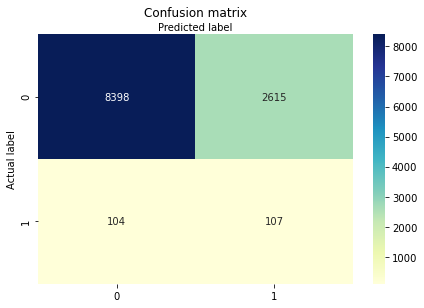

In [981]:
model.model_performance()

### Model 2 all brands included

In [982]:
dataset_allBrands = dataset.astype('float')
target = 'Incidence_1'

y = dataset_allBrands[target]
X = dataset_allBrands.drop(target, axis=1)
X = sm.add_constant(X)

In [983]:
odd_price = []
even_price = []
price_ends_with_9 = []

for column in X[price_dummies.columns].columns:
    try:
        is_odd = int(column[-1]) % 2
        is_9 = column[-1] == '9'
        is_aeq_5 = int(column[-1]) >= 5
        if is_odd and is_aeq_5:
            odd_price.append(column)
        elif (not is_odd) and is_aeq_5:
            even_price.append(column)
        if is_9:
            price_ends_with_9.append(column)
    except:
        pass

X['ends_with_9'] = X[price_ends_with_9].sum(axis=1).apply(lambda x: int(x!=0)) 
X['odd_price'] = X[odd_price].sum(axis=1).apply(lambda x: int(x!=0))      
X['even_price_above_5'] = X[even_price].sum(axis=1).apply(lambda x: int(x!=0))

In [984]:
# Dropping columns that cause multicollinearity
excluding = ['ID', 'Quantity','Brand_1', 'Brand_2', 'Brand_4', 'Brand_5', 'Brand_3', 
            'const', 'Price_4', 'change_in_P5', 'change_in_P3', 'Price_2', 
            'Price_3', 'odd_price', 'Price_5', 'Age', 'Income', 'Promotion_2_1', 
             'Last_Inc_Brand_3', 'change_in_P4', 'Price_1_1.48','Promotion_3_1',
            'Occupation_1', 'Education_1', 'Marital status_1', 'Promotion_1_1',
            'Day', 'change_in_P1', 'ends_with_9', 'Settlement size_1', 
             'Sex_1', 'Last_Inc_Brand_1']


other = ['Price_1_1.21', 'Price_1_1.33', 'Price_1_1.34', 'Price_1_1.35',
       'Price_1_1.42', 'Price_1_1.5', 'Price_1_Other', 'Price_2_1.9',
       'Price_5_2.64', 'Price_5_2.66', 'Price_5_2.7', 'Price_3_2.0', 
        'Price_3_1.95', 'Price_3_1.91', 'Price_3_1.91']

drop = ['Price_2_1.81', 'Price_4_1.9', 'Price_1_1.52', 'Price_5_Other',
       'Price_3_1.96', 'Price_3_Other', 'Last_Inc_Brand_2', 'Price_4_2.24',
       'Price_2_1.89', 'Price_4_2.16', 'Price_4_2.21', 'Price_1_1.47', 
       'Price_5_2.67', 'Price_3_2.07', 'Price_5_2.8', 'Price_2_1.82', 
        'Price_3_2.06', 'Price_3_2.02', 'Price_2_1.52', 
       'Price_3_1.98', 'Price_2_1.83', 'Price_2_1.57', 
        'Price_4_2.12', 'Price_1_1.39', 'Price_4_2.09', 'Price_1_1.27',
       'Price_4_2.18', 'Price_5_2.68', 'Price_5_2.73',
       'Price_1_1.36', 'Price_3_1.94', 'Price_2_1.5', 'Price_4_1.97',
       'Price_4_2.26','Price_2_1.87', 'Price_4_1.98', 'Price_5_2.58', 
        'Price_5_2.78', 'Price_2_1.51',
       'Price_5_2.61', 'Price_2_1.85', 'Price_4_2.15', 'Price_5_2.59',
       'Price_2_1.86', 'Price_1_1.37', 'Price_2_1.35', 'Price_4_1.96',
       'Price_5_2.71', 'Price_5_2.62', 'Price_2_1.88', 'Price_2_1.8',
       'Price_5_2.76', 'Price_3_2.09', 'Price_3_2.01', 'Price_5_2.65',
       'Price_5_2.77', 'Price_5_2.49', 'Price_5_2.63',
       'Price_4_Other', 'Price_1_1.4', 'Price_2_1.26','Price_3_1.93', 
       'Price_1_1.41', 'Price_2_1.84', 'Price_2_1.58', 'Price_1_1.49',
       'Price_2_1.56', 'Price_1_1.26', 'Price_3_1.97', 'Price_1_1.51',
       'Price_5_2.69', 'Price_2_Other', 'Price_1_1.19', 'Price_5_2.79',
        'Price_1_1.46'] + excluding + other

X_final = X.drop(drop, axis=1)

In [985]:
model = Logit_model(X_final, y)
results = model.statLogit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.527487
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit             Pseudo R-squared:  0.062     
Dependent Variable:  Incidence_1       AIC:               46464.9292
Date:                2020-11-17 01:36  BIC:               46577.9301
No. Observations:    44019             Log-Likelihood:    -23219.   
Df Model:            12                LL-Null:           -24756.   
Df Residuals:        44006             LLR p-value:       0.0000    
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      5.0000                                         
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Price_1             -1.0553   0.0182 -58.0351 0.0000 -1.0910 -1.0197
Last_Inc_Brand_4     0.4414   0.0541   8.1661 0.0000  0.3355  0.5473
Last_Inc_Brand_5     1.0544   0.0464  22.7421 0.0000  0.9635  1.1453
Last_Inc_Quantity_1  0.5357   0.0345  15.5357 0.0000  0.4681  0.6032
Promotion_4_1        0.1312   0.0361   3.6358 0.0003  0.0605  0.2020
Promotion_5_1        0.3956   0.0584   6.7751 0.0000  0.2811  0.5100
Education_2         -0.1638   0.0346  -4.7319 0.0000 -0.2316 -0.0959
Education_3          1.3435   0.1366   9.8337 0.0000  1.0757  1.6113
Occupation_2         0.3137   0.0303  10.3461 0.0000  0.2543  0.3731
Settlement size_2   -0.0777   0.0253  -3.0658 0.0022 -0.1273 -0.0280
Price_3_1.99        -0.1429   0.0302  -4.7398 0.0000 -0.2020 -0.0838
change_in_P2        -0.9085   0.0889 -10.2165 0.0000 -1.0828 -0.7342
even_price_above_5   0.0771   0.0250   3.0833 0.0020  0.0281  0.1261
====================================================================

"""

In [986]:
model.vif().head()

,variables,VIF
0,Price_1,4.699116
12,even_price_above_5,3.099162
3,Last_Inc_Quantity_1,2.529086
2,Last_Inc_Brand_5,1.804123
9,Settlement size_2,1.526112


In [987]:
results.pvalues.sort_values(ascending=False).keys()

Index(['Settlement size_2', 'even_price_above_5', 'Promotion_4_1',
       'Education_2', 'Price_3_1.99', 'Promotion_5_1', 'Last_Inc_Brand_4',
       'Education_3', 'change_in_P2', 'Occupation_2', 'Last_Inc_Quantity_1',
       'Last_Inc_Brand_5', 'Price_1'],
      dtype='object')

In [988]:
results.predict(model.X1)[results.predict(model.X1) > 0.5]

46920    0.560325
20510    0.622817
32861    0.564105
21379    0.831801
906      0.548079
           ...   
1681     0.534526
40107    0.531557
37462    0.573746
26045    0.506763
48341    0.601900
Length: 1102, dtype: float64


ROC AUC Train 0.652
ROC AUC Test 0.64
-------------------------

Classification Report Train
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79     33012
         1.0       0.40      0.45      0.42     11007

    accuracy                           0.69     44019
   macro avg       0.60      0.61      0.61     44019
weighted avg       0.70      0.69      0.70     44019

-------------------------

Classification Report Test
              precision    recall  f1-score   support

         0.0       0.81      0.76      0.79     11043
         1.0       0.39      0.45      0.42      3631

    accuracy                           0.69     14674
   macro avg       0.60      0.61      0.60     14674
weighted avg       0.70      0.69      0.69     14674

-------------------------


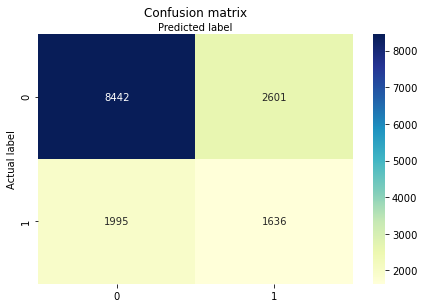

In [989]:
model.model_performance()

### Performing PCA and K-means clustering

In [990]:
price_dummies.head()

,Price_1_1.19,Price_1_1.21,Price_1_1.26,Price_1_1.27,Price_1_1.33,Price_1_1.34,Price_1_1.35,Price_1_1.36,Price_1_1.37,Price_1_1.39,...,Price_5_2.69,Price_5_2.7,Price_5_2.71,Price_5_2.73,Price_5_2.76,Price_5_2.77,Price_5_2.78,Price_5_2.79,Price_5_2.8,Price_5_Other
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [991]:
pca = PCA(n_components=30)
principalComponents = pca.fit_transform(price_dummies)


scaler_c = StandardScaler()
principalComponents = scaler_c.fit_transform(principalComponents)

dummy_components = pd.DataFrame(principalComponents).add_prefix('C')
dummy_components.head()

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29
0,0.028683,0.117099,-0.186201,-0.381890,-1.342020,1.725483,-1.010206,0.826144,1.521876,3.304485,...,-1.063395,0.166951,-0.239439,0.468394,0.601257,-0.284723,0.596133,0.393651,-0.095464,-0.228607
1,0.355194,-0.730677,0.899360,-1.458189,-1.472810,1.882672,-2.034324,-0.255746,0.099551,0.257565,...,-0.584142,0.591093,1.071031,-0.050267,0.332190,0.225974,-1.280728,0.250528,-0.730971,-0.280315
2,0.355194,-0.730677,0.899360,-1.458189,-1.472810,1.882672,-2.034324,-0.255746,0.099551,0.257565,...,-0.584142,0.591093,1.071031,-0.050267,0.332190,0.225974,-1.280728,0.250528,-0.730971,-0.280315
3,-0.200753,-0.596040,1.060988,-0.897759,-0.842341,1.283915,-1.518175,0.123002,0.079173,1.703290,...,-1.235458,1.493388,-0.032052,0.674806,0.468546,0.388471,-1.517450,0.548441,-0.869315,-0.012000
4,0.358308,-0.775129,0.890602,-1.437040,-1.475220,1.870047,-2.023451,-0.240956,0.083197,0.254644,...,-0.832912,0.974140,0.214674,0.596926,0.419124,0.415059,-1.256636,0.230433,-0.894761,0.079462


In [992]:
pca.explained_variance_ratio_.sum()

0.8117492735065143

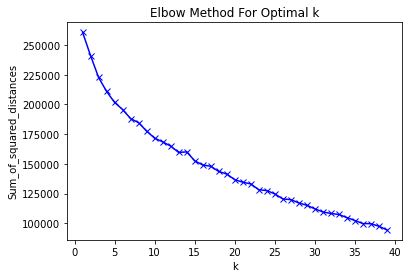

In [900]:
Sum_of_squared_distances = []
kmeans_data = price_dummies

K = range(1,40)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(kmeans_data)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# Conclusion: use 30

In [993]:
kmeans_clusters = KMeans(n_clusters=30, random_state=42).fit_transform(price_dummies)

scaler_k = StandardScaler()
kmeans_clusters = scaler_k.fit_transform(kmeans_clusters)

dummy_clusters = pd.DataFrame(kmeans_clusters).add_prefix('K')
dummy_clusters.head()

,K0,K1,K2,K3,K4,K5,K6,K7,K8,K9,...,K20,K21,K22,K23,K24,K25,K26,K27,K28,K29
0,0.261173,0.757588,0.731423,0.414330,0.510460,-1.548949,0.372763,-0.669451,0.711989,0.846558,...,0.442137,0.871356,0.339596,0.487065,-0.350198,0.611575,0.295156,0.385456,0.365498,-1.050426
1,0.482562,-0.024392,-0.155612,-0.663818,0.140659,-1.719891,-0.255959,0.411533,-0.220164,-0.544274,...,0.442137,-0.059254,0.339596,-0.604775,-0.413339,-0.269777,-0.134392,0.385456,0.274090,-4.948653
2,0.482562,-0.024392,-0.155612,-0.663818,0.140659,-1.719891,-0.255959,0.411533,-0.220164,-0.544274,...,0.442137,-0.059254,0.339596,-0.604775,-0.413339,-0.269777,-0.134392,0.385456,0.274090,-4.948653
3,0.544252,-0.024392,0.148375,0.333239,0.140659,-0.832663,0.372763,0.411533,-0.327263,-0.310417,...,0.442137,0.013628,0.339596,0.487065,-0.413339,0.611575,0.688672,0.385456,0.491227,-3.462892
4,0.544252,-0.024392,-0.155612,-0.663818,0.140659,-1.764966,0.372763,0.411533,-0.220164,-0.544274,...,0.442137,-0.059254,0.339596,-0.604775,-0.413339,-0.269777,-0.134392,0.385456,0.274090,-4.874624


In [994]:
dataset_with_components = pd.concat([dataset.drop(price_dummies.columns, axis=1), dummy_components], axis=1)
dataset_with_clusters = pd.concat([dataset.drop(price_dummies.columns, axis=1), dummy_clusters], axis=1)

### Final Model with dimensionally reduced dummies and all brands included

In [1094]:
# Using dataset_with_components and dataset_with_clusters
dataset_final = dataset_with_components.astype('float')
target = 'Incidence_1'

y = dataset_final[target]
X = dataset_final.drop(target, axis=1)
X = sm.add_constant(X)

In [1095]:
# Dropping columns that cause multicollinearity
excluding = ['ID', 'Quantity','Brand_1', 'Brand_2', 'Brand_4', 'Brand_5', 'Brand_3', 
            'const', 'change_in_P5', 'change_in_P3','change_in_P4', 'change_in_P1',
             'Price_3', 'Price_5', 'Price_4', 'Price_2', 'Age', 'Income', 
             'Last_Inc_Brand_2', 'Settlement size_2', 'Promotion_4_1', 'Day', 
            'Education_1', 'Marital status_1', 'Last_Inc_Brand_1', 
             'Promotion_3_1', 'Last_Inc_Brand_3', 'Sex_1','Promotion_1_1',
            'Settlement size_1', 'Occupation_1']

drop_components = ['C11', 'C28', 'C2', 'C15', 'C26', 'C22', 'C20', 'C0', 'C25', 'C27', 'C7',
       'C12', 'C24', 'C10', 'C19', 'C3', 'C9', 'C23', 'C16', 'C13', 'C14', 'C17', 'C29']

drop = drop_components + excluding 

X_final = X.drop(drop, axis=1)

In [1096]:
model_3 = Logit_model(X_final, y)
results = model_3.statLogit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.525550
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit             Pseudo R-squared:  0.066     
Dependent Variable:  Incidence_1       AIC:               46302.4078
Date:                2020-11-17 01:57  BIC:               46450.1782
No. Observations:    44019             Log-Likelihood:    -23134.   
Df Model:            16                LL-Null:           -24756.   
Df Residuals:        44002             LLR p-value:       0.0000    
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      6.0000                                         
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Price_1             -1.0649   0.0130 -81.6184 0.0000 -1.0905 -1.0394
Last_Inc_Brand_4     0.4582   0.0542   8.4510 0.0000  0.3519  0.5644
Last_Inc_Brand_5     1.0736   0.0465  23.0690 0.0000  0.9824  1.1648
Last_Inc_Quantity_1  0.5106   0.0346  14.7436 0.0000  0.4428  0.5785
Promotion_2_1        0.0851   0.0278   3.0632 0.0022  0.0306  0.1395
Promotion_5_1        0.4044   0.0585   6.9125 0.0000  0.2897  0.5190
Education_2         -0.1625   0.0346  -4.6931 0.0000 -0.2304 -0.0946
Education_3          1.4007   0.1364  10.2719 0.0000  1.1334  1.6679
Occupation_2         0.2960   0.0298   9.9476 0.0000  0.2377  0.3544
change_in_P2        -0.7067   0.0963  -7.3402 0.0000 -0.8954 -0.5180
C1                   0.0429   0.0116   3.6987 0.0002  0.0201  0.0656
C4                   0.0477   0.0117   4.0766 0.0000  0.0248  0.0706
C5                  -0.0985   0.0121  -8.1571 0.0000 -0.1221 -0.0748
C6                   0.0650   0.0123   5.2774 0.0000  0.0409  0.0892
C8                   0.0681   0.0116   5.8640 0.0000  0.0454  0.0909
C18                 -0.0412   0.0117  -3.5252 0.0004 -0.0642 -0.0183
C21                 -0.0503   0.0113  -4.4412 0.0000 -0.0725 -0.0281
====================================================================

"""

In [1097]:
model_3.vif().head()

,variables,VIF
3,Last_Inc_Quantity_1,2.544906
0,Price_1,2.320126
4,Promotion_2_1,1.904204
2,Last_Inc_Brand_5,1.806747
1,Last_Inc_Brand_4,1.444416


In [1100]:
results.pvalues.sort_values(ascending=False).keys()

Index(['Promotion_2_1', 'C18', 'C1', 'C4', 'C21', 'Education_2', 'C6', 'C8',
       'Promotion_5_1', 'change_in_P2', 'C5', 'Last_Inc_Brand_4',
       'Occupation_2', 'Education_3', 'Last_Inc_Quantity_1',
       'Last_Inc_Brand_5', 'Price_1'],
      dtype='object')

In [1101]:
dummy_comps = dummy_components.columns.to_list()

dataset_final[dummy_comps+['Incidence_1']].corr()['Incidence_1'].sort_values(ascending=False)

Incidence_1    1.000000
C6             0.044028
C8             0.020332
C14            0.019109
C3             0.014641
C4             0.013535
C13            0.013393
C1             0.010487
C25            0.010017
C17            0.008336
C22            0.008254
C16            0.006398
C15            0.005084
C26            0.004128
C11            0.002884
C20            0.002773
C24           -0.000063
C7            -0.000712
C23           -0.006022
C27           -0.008832
C0            -0.009385
C28           -0.010143
C10           -0.010709
C19           -0.010998
C12           -0.011688
C2            -0.014099
C29           -0.014391
C9            -0.017921
C18           -0.023866
C21           -0.028206
C5            -0.050661
Name: Incidence_1, dtype: float64

In [1102]:
components_to_explain = ['C18', 'C1', 'C4', 'C21', 'C6', 'C8', 'C5']

explain = explain_components(price_dummies, dummy_components[components_to_explain])
explain.loc[1:].head(12)

,C18,C1,C4,C21,C6,C8,C5
1,Price_3_2.09,Price_4_2.24,Price_4_2.12,Price_2_1.26,Price_5_2.67,Price_1_1.47,Price_4_2.09
2,Price_2_1.82,Price_3_2.06,Price_1_1.47,Price_3_1.96,Price_2_1.52,Price_5_2.64,Price_1_1.5
3,Price_5_2.8,Price_5_2.79,Price_3_1.95,Price_1_1.37,Price_1_1.27,Price_4_2.18,Price_5_2.66
4,Price_1_1.51,Price_2_1.85,Price_5_2.67,Price_5_2.66,Price_2_1.26,Price_3_2.01,Price_3_1.99
5,Price_5_2.69,Price_1_1.42,Price_3_1.91,Price_2_Other,Price_3_1.96,Price_3_2.0,Price_1_1.47
6,Price_1_1.48,Price_5_2.77,Price_1_1.27,Price_1_1.34,Price_1_1.35,Price_4_1.9,Price_4_1.97
7,Price_1_1.49,Price_1_1.5,Price_2_1.52,Price_5_2.65,Price_4_1.97,Price_4_1.96,Price_1_1.52
8,Price_1_1.5,Price_5_2.78,Price_2_1.9,Price_3_1.91,Price_1_1.37,Price_5_2.66,Price_2_1.87
9,Price_2_Other,Price_5_2.76,Price_4_1.9,Price_2_1.86,Price_3_2.07,Price_4_Other,Price_1_1.35
10,Price_1_1.21,Price_5_2.8,Price_4_1.97,Price_1_1.52,Price_3_1.95,Price_5_2.69,Price_4_2.26



ROC AUC Train 0.652
ROC AUC Test 0.64
-------------------------

Classification Report Train
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79     33012
         1.0       0.40      0.45      0.42     11007

    accuracy                           0.69     44019
   macro avg       0.60      0.61      0.61     44019
weighted avg       0.70      0.69      0.70     44019

-------------------------

Classification Report Test
              precision    recall  f1-score   support

         0.0       0.81      0.76      0.79     11043
         1.0       0.39      0.45      0.42      3631

    accuracy                           0.69     14674
   macro avg       0.60      0.61      0.60     14674
weighted avg       0.70      0.69      0.69     14674

-------------------------


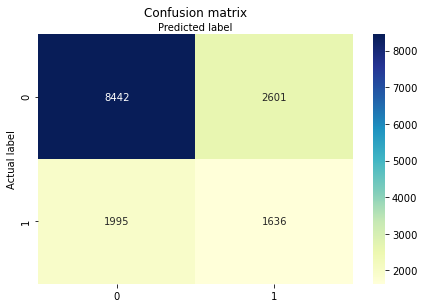

In [1103]:
model.model_performance()

## Saving the dataset

In [1106]:
dataset.head()

,ID,Day,Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Age,Income,...,Price_5_2.77,Price_5_2.78,Price_5_2.79,Price_5_2.8,Price_5_Other,change_in_P1,change_in_P2,change_in_P3,change_in_P4,change_in_P5
0,100000001,1,0,1.59,1.87,2.01,2.09,2.66,67,124670,...,0,0,0,0,0,-0.050314,0.010695,-0.009950,0.0,0.0
1,100000001,11,0,1.51,1.89,1.99,2.09,2.66,67,124670,...,0,0,0,0,0,-0.050314,0.010695,-0.009950,0.0,0.0
2,100000001,12,0,1.51,1.89,1.99,2.09,2.66,67,124670,...,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.0
3,100000001,16,0,1.52,1.89,1.98,2.09,2.66,67,124670,...,0,0,0,0,0,0.006623,0.000000,-0.005025,0.0,0.0
4,100000001,18,0,1.52,1.89,1.99,2.09,2.66,67,124670,...,0,0,0,0,0,0.000000,0.000000,0.005051,0.0,0.0


In [1108]:
dataset.to_csv('charm_pricing.csv')